<a href="https://colab.research.google.com/github/SumitraMukherjee/TwoNotTouch/blob/main/2notTouch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TwoNotTouch
This notebook allows you to:

- Interactively specify a TwoNotTouch puzzle
- Solve the puzzle using Z3 solver
- Interactively obtain hints
- Print the puzzle and its solution


OPTIONS: 



Choose Region: 




 Specify regions  for all cells:



GridBox(children=(Button(layout=Layout(border='1px solid', height='50px', width='100%'), style=ButtonStyle(but…


 Click after ALL regions are specified:



Button(description='Puzzle specified', layout=Layout(border='5px solid', height='50px', width='300px'), style=…

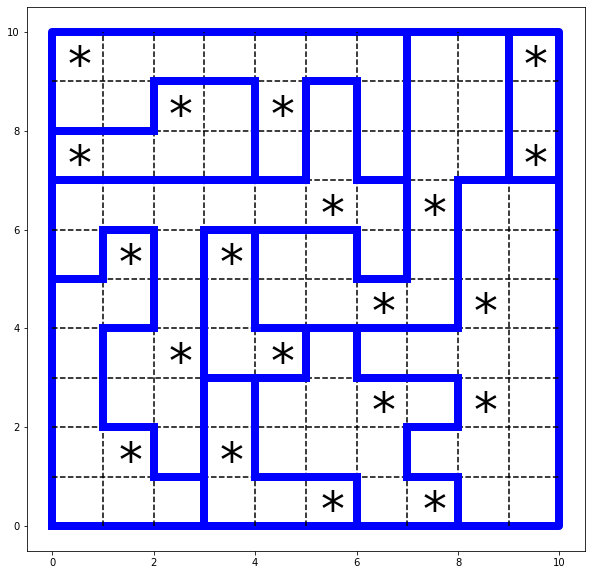


 Click on a cell to see value:



GridBox(children=(Button(layout=Layout(border='1px solid', height='50px', width='100%'), style=ButtonStyle(but…

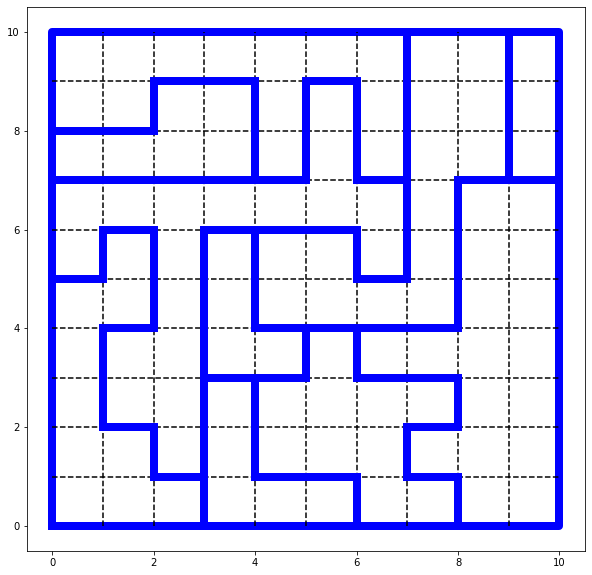

In [1]:
! pip install z3-solver
from z3 import *
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display

class TwoNotTouch:
    def __init__(self):
        self.cell = None
        self.region = dict((i,[]) for i in range(10))
        self.solution = None
        self.current_region = 10
        self.color = ['AntiqueWhite', 'Aqua', 'Aquamarine', 'CadetBlue', 'Chartreuse', 'Coral', 'CornflowerBlue', 'Gold', 'GoldenRod', 'HotPink', 'AliceBlue']
        

    # SOLVE PUZZLE
    def solve(self):
        
        def nbs(r,c): # returns neighbors or (r,c)
            cells = [(r+i, c+j) for i in range(-1,2,1) for j in range(-1,2,1)]
            return [(i,j) for i,j in cells if (i,j)!= (r,c) and min(i,j)>=0 and max(i,j)<10]

        X = {(r,c): Int(f'X[({r},{c})]') for r in range(10) for c in range(10)}
        sol = Solver()
        for r in range(10): # 2 in row
            sol.add(sum([X[(r,c)] for c in range(10)])==2)
        for c in range(10): # 2 in col
            sol.add(sum([X[(r,c)] for r in range(10)])==2)
        for r in self.region: # 2 in region
            sol.add(sum([X[(r,c)] for (r,c) in self.region[r]])==2)
        
        for r in range(10): 
            for c in range(10):
                sol.add(And(X[(r,c)]>= 0, X[(r,c)]<=1))
                cells = nbs(r,c)
                sol.add(Or(X[(r,c)]==0, sum([X[(i,j)] for (i,j) in cells])==0))
   
        if sol.check() != sat:
            print("Solution not found")
            return

        m = sol.model() # get solutions
        self.solution = [[m[X[(r,c)]] for c in range(10)] for r in range(10)]

    ## DISPLAY PUZZLE
    def display(self, sol=False):
        X = self.solution
        plt.figure(figsize=(10,10))
        plt.plot([0,10,10,0,0],[0,0,10,10,0], color='b', linewidth=8)
        for i in range(1,10):
            plt.plot([i,i],[0,10], linestyle='--', color='black')
            plt.plot([0,10],[i,i], linestyle='--', color='black')

        for x in range(10):
            for y in range(10):
                if (x+1,y) in self.cell and self.cell[(x,y)] != self.cell[(x+1,y)]:
                    plt.plot([x+1,x+1],[y,y+1], color='b', linewidth=8)
                if (x,y+1) in self.cell and self.cell[(x,y)] != self.cell[(x,y+1)]:
                    plt.plot([x,x+1],[y+1,y+1], color='b', linewidth=8)
                if sol==True and X[x][y] == 1:
                    plt.text(x+0.3,y, '*', fontsize=48)
        plt.show()

    ## SPECIFY PUZZLE
    def specify(self):
    
        def on_region_selected(b):
            self.current_region = b.value

        def on_cell_clicked(b):
            b.value = self.current_region
            b.description = f'R{self.current_region}'
            b.style = {'button_color': self.color[self.current_region]} # assign color

        def on_done_clicked(b):
            self.cell = dict((c, cellB[c].value) for c in cellB)
            for c in self.cell:
                self.region[self.cell[c]].append(c)
            self.solve()

        regionB = {} # regionB[i] contains button b for region i (b.value == i) 
        for i in range(10):
            regionB[i] = widgets.Button(description = f'R{i}',
                                        layout=widgets.Layout(width='50px', height='50px', border="1px solid"),
                                        style = {'button_color': self.color[i]})
            regionB[i].value = i
            regionB[i].on_click(on_region_selected)

        print('Choose Region: \n')
        display(widgets.HBox([regionB[i] for i in range(10)]))

        # specify dictionary cell with buttons to assign region to cell
        cellB = {} # cellB[(x,y)] contains button b for cell (x,y) with value current_region
        for x in range(10):
            for y in range(10): 
                cellB[(x,y)] = widgets.Button(layout=widgets.Layout(width='100%', height='50px', border="1px solid"),
                                              style = {'button_color': self.color[10]})
                cellB[(x,y)].on_click(on_cell_clicked)

        clist = [cellB[(x,y)] for y in range(9,-1,-1) for x in range(10)] # arrange cell buttons in grid

        print('\n Specify regions  for all cells:\n')
        display(widgets.GridBox(children=clist, layout=widgets.Layout(grid_template_columns="repeat(10, 50px)")))

            
        print('\n Click after ALL regions are specified:\n')
        done = widgets.Button(description = "Puzzle specified",
                              layout=widgets.Layout(width='300px', height='50px', border="5px solid"))
        done.on_click(on_done_clicked)
        display(done)

    # HINTS
       
    def hints(self):

        def on_hint_clicked(b):
            x,y = b.value
            b.description = 'X' if self.solution[x][y]==1 else 'o'

        # specify dictionary cell with buttons to assign region to cell
        cellB = {}
        for x in range(10):
            for y in range(10):
                cellB[(x,y)] = widgets.Button(layout=widgets.Layout(width='100%', height='50px', border="1px solid"),
                                              style = {'button_color': self.color[self.cell[(x,y)]]})
                cellB[(x,y)].value = (x,y)
                cellB[(x,y)].on_click(on_hint_clicked)

        clist = [cellB[(x,y)] for y in range(9,-1,-1) for x in range(10)]

        print('\n Click on a cell to see value:\n')
        display(widgets.GridBox(children=clist, layout=widgets.Layout(grid_template_columns="repeat(10, 50px)")))

## TOP level interface
puz = TwoNotTouch()

def puz_specify(b):
    puz.specify()

def puz_display(b):
    puz.display()

def sol_display(b):
    puz.display(True)

def puz_hints(b):
    puz.hints()

spec = widgets.Button(description = "Specify Puzzle",
                      layout=widgets.Layout(width='200px', height='50px', border="5px solid"))
spec.on_click(puz_specify)

print_p = widgets.Button(description = "Print Puzzle",
                         layout=widgets.Layout(width='200px', height='50px', border="5px solid"))
print_p.on_click(puz_display)

print_s = widgets.Button(description = "Print Solution",
                         layout=widgets.Layout(width='200px', height='50px', border="5px solid"))
print_s.on_click(sol_display)

get_hint = widgets.Button(description = "Get Hints",
                          layout=widgets.Layout(width='200px', height='50px', border="5px solid"))
get_hint.on_click(puz_hints)

print('\nOPTIONS: \n')
display(widgets.HBox([spec, print_p, print_s, get_hint])) 